In [27]:
import os
import pandas as pd

%pylab inline

base_dir = os.path.join( '.','data')
output_dir = os.path.join( '.','output')
ciudad = 'Valledupar'
fuente = 'IDEAM'
serie_csv = os.path.join(base_dir,ciudad,fuente+'.csv')
serie_pd = pd.read_csv(serie_csv, sep = ';',
                encoding='latin-1')
                
base_dir = os.path.join( '.','data')
output_dir = os.path.join( '.','output')
ciudad = 'Valledupar'
fuente = 'NREL'
serie_csv1 = os.path.join(base_dir,ciudad,fuente+'.csv')
serie_pd1 = pd.read_csv(serie_csv1, sep = ';',
                encoding='latin-1')
serie_ajus = serie_pd1.copy()

Populating the interactive namespace from numpy and matplotlib


In [28]:
def mcp(serie_real,serie_satel,serie_pd1,serie_ajustada): 
    
    
    my= serie_real["IDEAM"].mean()
    mx= serie_satel["NREL"].mean()
    dy= serie_real["IDEAM"].std(ddof=0)
    dx= serie_satel["NREL"].std(ddof=0)
    
    fx_serie_ajustada = pd.DataFrame((my-((dy/dx)*mx))+((dy/dx)*serie_pd1["NREL"]))
    
    fx_serie_ajustada[fx_serie_ajustada<0]=0
    
    del serie_ajustada['NREL']        
    serie_ajustada['PromedioDia']=fx_serie_ajustada
    
    return (serie_ajustada)

In [46]:
anho = 2006
mes = 1

serie_ideam_short = serie_pd[(serie_pd['AÑO'] == anho) &
                        (serie_pd['MES'] <= mes)]

serie_sat_short = serie_pd1[(serie_pd1['AÑO'] == anho) &
                        (serie_pd1['MES'] <= mes)]

In [47]:
mcp(serie_ideam_short,serie_sat_short,serie_pd1,serie_ajus)
serie_ajustada=pd.DataFrame(serie_ajustada)

KeyError: 'NREL'

In [48]:
def Energia (serie):   
    def ghi_mensual(serie_horaria):
        agnos = sorted(serie_horaria['AÑO'].unique())
        ghi_df = pd.DataFrame(columns=["AÑO", "MES", "DIAS", "PromedioMes"])
        for agno in range(2006,2016):
            for mes in range(1,13):
                nombre_energia = list(serie_horaria)[-1]
                dias = sorted(serie_horaria[(serie_horaria['AÑO'] == agno) &
                            (serie_horaria['MES'] == mes)]["DIA"].unique())
                ghi_mes = serie_horaria.loc[((serie_horaria["AÑO"] == agno)
                                & (serie_horaria["MES"] == mes)),
                                            nombre_energia].sum()/1000
                ghi_dict = {"AÑO":agno, "MES":mes, "DIAS":dias[-1],
                            "PromedioMes":ghi_mes}
                ghi_df = ghi_df.append(ghi_dict, ignore_index=True)
        return ghi_df

    def ghi_dia(serie_ghi_mensual):
            agnos = sorted(serie_ghi_mensual['AÑO'].unique())
            ghi_df = pd.DataFrame(columns=["AÑO", "MES", "PromedioDia"])
            for agno in agnos:
                for mes in range(1,13):
                    dias = serie_ghi_mensual.loc[((serie_ghi_mensual["AÑO"] == agno)
                                    & (serie_ghi_mensual["MES"] == mes))
                                             ,"DIAS"].item()
                    ghi_diario = serie_ghi_mensual.loc[(
                        (serie_ghi_mensual["AÑO"] == agno)
                                    & (serie_ghi_mensual["MES"] == mes)),
                        "PromedioMes"].item()/dias
                    ghi_dict = {"AÑO":agno, "MES":mes, "PromedioDia":ghi_diario}
                    ghi_df = ghi_df.append(ghi_dict, ignore_index=True)
            return ghi_df
    
    ghi_mens_cal = ghi_mensual(serie)
    ghi_dia_cal = ghi_dia(ghi_mens_cal)
    data = sorted(ghi_dia_cal["PromedioDia"])
    num = range(len(data))
    percentil = 0.01
    enficc = ghi_dia_cal.quantile(q=percentil, numeric_only=True)["PromedioDia"]
    print('La ENFICC 99% es: ', enficc)

    return (enficc, data, num)

In [49]:
enficc_real = Energia(serie_pd)
enficc_sat = Energia(serie_pd1)
enficc_ajus = Energia(serie_ajustada)

La ENFICC 99% es:  4.56900737661
La ENFICC 99% es:  5.06672598387
La ENFICC 99% es:  4.65542321573


In [50]:
def graf(data_ideam, data_nrel, data_ajust):

    pylab.xlabel("Datos")
    pylab.ylabel("Energía/Energía Base IDEAM")
    pylab.plot(data_ideam[-1],data_ideam[1]/data_ideam[1][0],'-k', label='IDEAM')
    pylab.plot(data_nrel[-1],data_nrel[1]/data_ideam[1][0],'-r', label='NREL')
    pylab.plot(data_ajust[-1],data_ajust[1]/data_ideam[1][0],'-b', label='Ajustados')
    pylab.legend(loc='upper left')

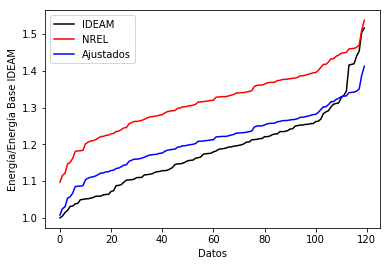

In [51]:
graf(enficc_real, enficc_sat, enficc_ajus)

In [61]:
serie_ajus_short = serie_ajustada[(serie_ajustada['AÑO'] == anho) &
                        (serie_ajustada['MES'] <= mes)]

ideam_val=serie_ideam_short.values
ajus_val=serie_ajus_short.values
max_ideam=np.max(ideam_val)
min_ideam=np.min(ideam_val)

def RMS(obs,aju):
    rms = (sqrt((obs-aju)**2).mean())/(max_ideam-min_ideam)
    print("El error rms es: " + str(rms))
    return rms
def MBE(obs,aju):
    mbe_val = (sum(obs-aju))/sum(obs)
    print("El error mbe es: " + str(mbe_val))
    return mbe_val

In [62]:
rms1 = RMS(ideam_val,ajus_val)
mbe1= MBE(ideam_val,ajus_val)

El error rms es: 0.00510803022299
El error mbe es: 0.000296366314774
